In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'NanumGothic'
%matplotlib inline

from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  ExtraTreesRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
import xgboost as xgb
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import warnings
warnings.filterwarnings(action='ignore')

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.callbacks import ModelCheckpoint, EarlyStopping

Using TensorFlow backend.


# 1. 데이터 로드 및 확인

In [2]:
# data loding
data = pd.read_csv('C:/Users/User/Desktop/Python/lesson/test.csv')

In [3]:
data.head()

,a,b,c,d,e
0,93.870091,70.876745,2.354900,9.551207,57.307517
1,84.580716,35.750496,47.173690,96.223018,59.646539
2,60.922867,12.552629,13.446080,48.074885,29.284720
3,6.201266,68.697753,27.297359,52.496803,35.854795
4,51.077351,12.802865,45.022822,30.914718,42.093988


In [4]:
data.describe()

,a,b,c,d,e
count,150.000000,150.000000,150.000000,150.000000,150.000000
mean,50.703865,51.811357,54.218765,52.955921,56.929779
std,29.527882,29.710899,29.165934,28.494519,15.485955
min,0.707750,0.007267,0.941293,1.700373,14.416505
25%,25.399403,24.381230,32.129501,29.096766,46.696919
50%,51.803993,54.049843,57.816471,54.560238,55.786632
75%,80.345477,77.937961,79.225373,79.881310,67.258204
max,99.006803,99.212584,99.722818,99.344110,93.572076


<AxesSubplot:xlabel='e'>

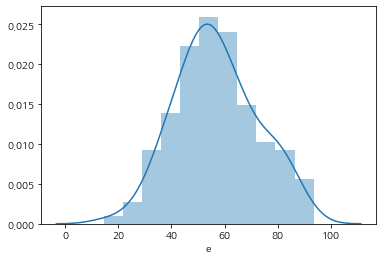

In [5]:
sns.distplot(data['e'])

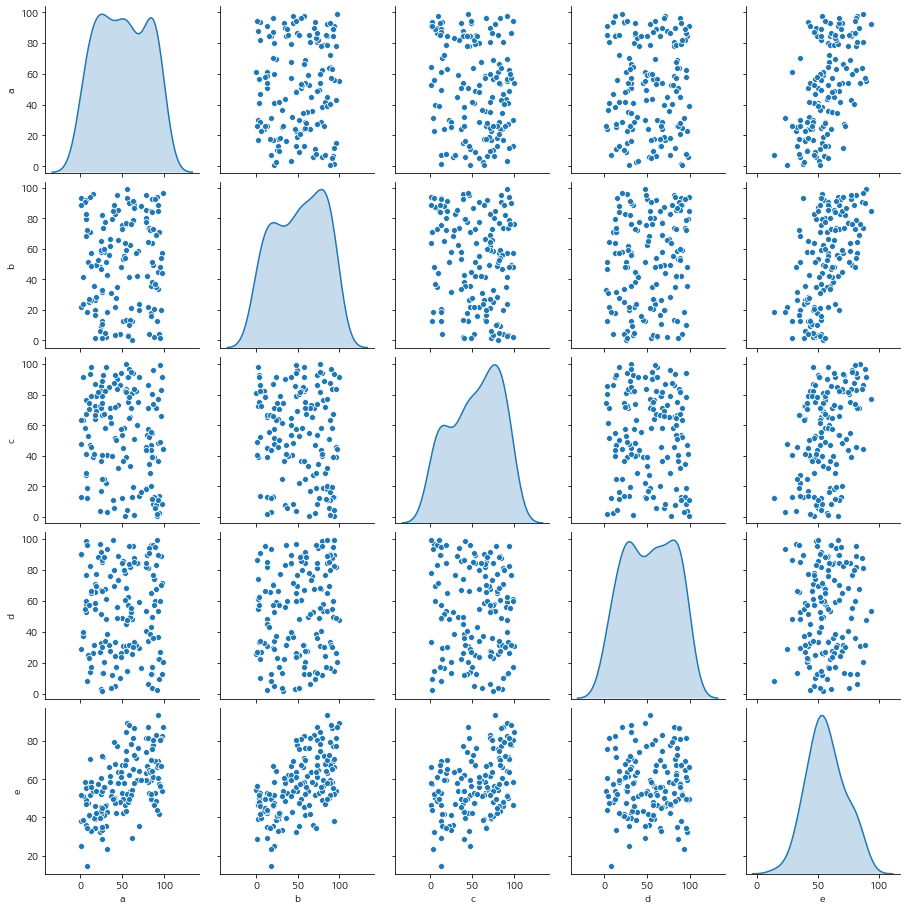

In [6]:
sns.pairplot(data[["a", "b", "c", "d", "e"]], diag_kind="kde")

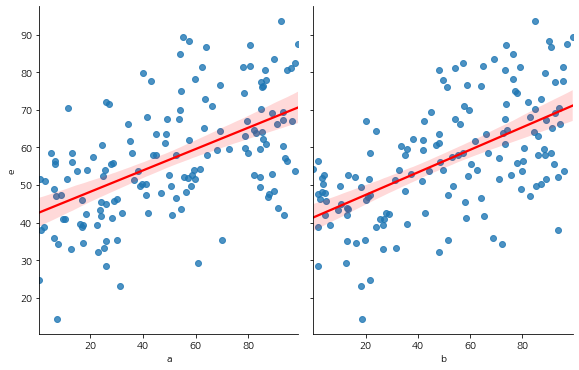

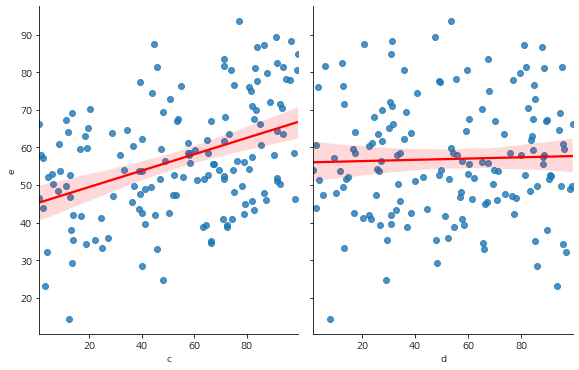

In [7]:
sns.pairplot(data, x_vars=["a", "b"], y_vars=["e"], size = 5, aspect=.8, kind="reg", plot_kws={'line_kws':{'color':'red'}})
sns.pairplot(data, x_vars=["c", "d"], y_vars=["e"], size = 5, aspect=.8, kind="reg", plot_kws={'line_kws':{'color':'red'}})

<AxesSubplot:>

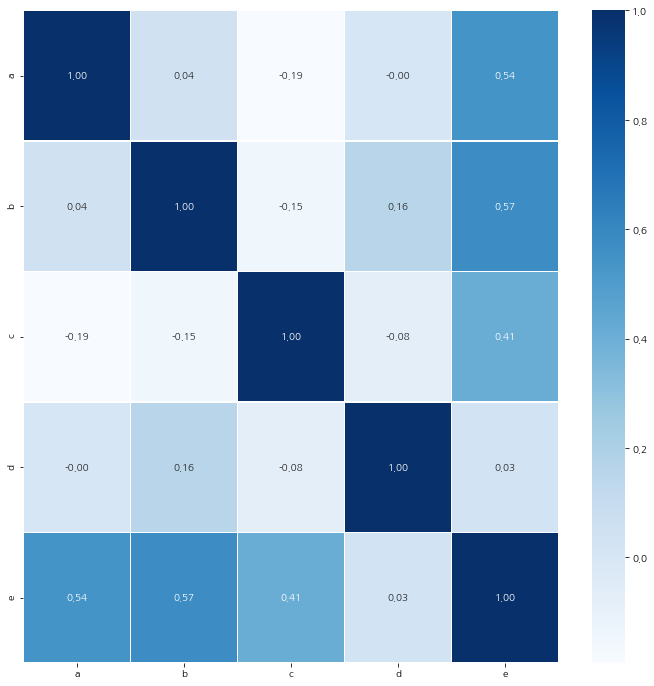

In [8]:
# Correlation Analysis
# 상관계수 분석
plt.figure(figsize=(12,12))
sns.heatmap(data = data.corr(method='pearson'), annot=True, fmt = '.2f', linewidths=.5, cmap='Blues')

### 공선성 확인 & 정규화

In [9]:
# Feature Engineering
# 새로운 변수를 만든다음에 상관계수를 재확인 - 변수간 상관관계 없으므로 불필요
# 범주형 변수 인코딩 및 불필요한 변수 제거 - 범주형 변수 없음 / 불필요한 변수 없음
# 결측값은 없으므로 따로 처리하지 않음
# Explanatory variable X(설명변수), Response variable Y(반응변수)
X = data.drop('e', axis=1)
y = data['e']

feature_name = X.columns

In [10]:
# Multicollinearity Check - 변수간 상관관계 없지만, 확인용

'''
# 다중공선성(Multicollinearity) : 독립변수의 일부가 다른 독립변수의 조합으로 표현될수 있는 경우.
#                                 독립변수들이 서로 독립이 아니라 상호상관관계가 강한 경우에 발생.
#                                 즉, 독립변수들 간에 강한 상관관계가 나타나는 문제이다.

# 다중공선성 문제를 피하기 위해 VIF(분산 팽창 지수, Variance Inflation Factor)를 사용하여 변수들 정리
# VIF는 독립변수를 다른 독립변수로 선형회귀한 성능을 나타낸것.
# 일반적으로 VIF가 5이상(80%)일때 다중공선성 문제를 의심할수 있으며, 10이상(90%)일 경우 다중공선성문제가 존재한다고 판단한다.

# 상관관계 : 두 변수간의 상관정도를 계산하고, 독립변수와 종속변수를 구분하지 않는다.
# 다중공선성 : 두개 이상의 변수들 간의 상관정도를 계산하고, 독립변수들 간의 관계만을 고려한다.
'''

from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = feature_name
print(vif)

   VIF Factor features
0    2.973971        a
1    3.468769        b
2    2.773433        c
3    3.722553        d


In [11]:
rc = RobustScaler()
X = rc.fit_transform(X)

# 2. 머신러닝 실습

In [12]:
# Data Split
seed = 100
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)

In [13]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape, 

((105, 4), (105,), (45, 4), (45,))

In [14]:
y_train.std(), y_test.std()

(16.4202132678065, 13.183313918063604)

### 회귀모델 만들기

In [15]:
Lasso = Lasso(alpha =0.0005, random_state=seed)

In [16]:
ENet = ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=seed)

In [17]:
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)

In [18]:
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =seed)

In [19]:
XGB = xgb.XGBRegressor(learning_rate=0.01,n_estimators=1800,
                                     max_depth=3, min_child_weight=2,
                                     gamma=0.05, subsample=0.9,
                                     colsample_bytree=0.7, random_state =seed,
                                     objective='reg:linear', silent=True)

In [20]:
LGB = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

### 교차검증 & 모델 성능 확인(MAE)

In [21]:
regs = {'Lasso' : Lasso, 'ENet' : ENet, 'KRR' : KRR, 'GBoost' : GBoost, 'XGB' : XGB, 'LGB' : LGB}

In [22]:
def train_regressor(reg, X_train, y_train):    
    reg.fit(X_train, y_train)
    
def predict_values(reg, X_test):
    return (reg.predict(X_test))

#Validation function
n_folds = 5
def mae_cv(reg, X_train, y_train):
    kf = KFold(n_folds, shuffle=True, random_state=seed).get_n_splits(X_train)
    mae= -cross_val_score(reg, X_train, y_train, scoring="neg_mean_absolute_error", cv = kf)
    return(mae)

In [23]:
cv_scores = []
for k,v in regs.items():
    cv_scores.append((k, mae_cv(v, X_train, y_train).mean()))

In [24]:
df_cv = pd.DataFrame.from_dict(dict(cv_scores), orient='index', columns=['MAE(교차검증)'])
df_cv

,MAE(교차검증)
Lasso,2.557110
ENet,2.557124
KRR,2.493036
GBoost,3.503030
XGB,4.102886
LGB,3.058491


In [25]:
pred_scores = []
for k,v in regs.items():
    train_regressor(v, X_train, y_train)
    pred = predict_values(v, X_test)
    pred_scores.append((k, np.mean([abs(y_test-pred)])))

In [26]:
df_pred = pd.DataFrame.from_dict(dict(pred_scores), orient='index', columns=['MAE(테스트셋)'])
df_pred

,MAE(테스트셋)
Lasso,2.403258
ENet,2.402566
KRR,2.475560
GBoost,3.780507
XGB,3.121264
LGB,3.853187


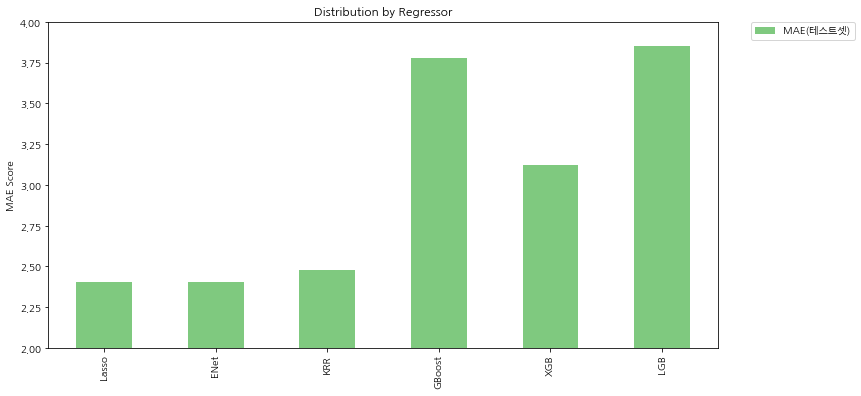

In [27]:
df_pred.plot(kind='bar', ylim=(2.0,4.0), figsize=(12,6), align='center', colormap="Accent")
plt.xticks(np.arange(6), df_pred.index)
plt.ylabel('MAE Score')
plt.title('Distribution by Regressor')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [28]:
# 예측결과 그래프 출력
def pred_vis(name, y_test_vis, y_pred_vis):
    y_test_m_vis = y_test_vis.to_numpy()
    plt.figure(figsize=(7,5))
    plt.title('%s Prediction' %name)
    plt.plot(y_test_m_vis, c='steelblue', alpha=1, lw=4, marker="o", ms=6, mec='steelblue', mew=3)
    plt.plot(y_pred_vis, c='darkorange', alpha=2, lw=4, marker="o", ms=6, mec='darkorange', mew=3)
    legend_list = ['y_test', 'y_pred']
    plt.xlabel('number of index', fontsize='12')
    plt.ylabel('e', fontsize='12')
    plt.legend(legend_list, loc=1, fontsize='12')
    plt.grid(True)
    plt.show()

In [29]:
model = ENet

In [30]:
pred = model.predict(X_test)

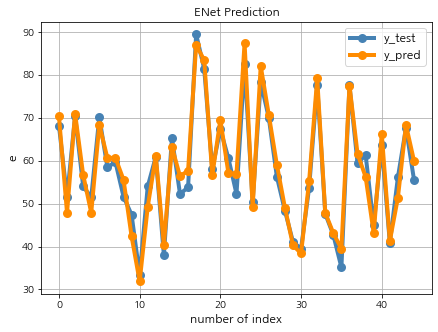

In [31]:
pred_vis('ENet', y_test, pred)

### 피쳐 중요도 평가 및 모델저장

In [32]:
# 변수별 기여도 평가용 함수
def r2_est(model, X_train, y_train, X_test, y_test):
    return r2_score(y_test, model.fit(X_train, y_train).predict(X_test))

# 변수별 R2 기여도 평가
mae_impact = list()
for j in range(X_train.shape[1]):
    selection = [i for i in range(X_train.shape[1]) if i != j]
    mae_impact.append(((r2_est(model, X_train, y_train, X_test, y_test) - r2_est(model, X_train[:,selection], y_train, X_test[:,selection], y_test)), data.columns[j]))
for imp, varname in sorted(mae_impact, reverse=True):
    print('%6.3f %s'%(imp, varname))

 0.585 b
 0.495 a
 0.468 c
 0.001 d


In [33]:
'''
# 모델 저장
pkl_filename = "C:/Users/sese3/Desktop/Python/seoul metro/model_xgb_2.h5"
with open(pkl_filename, 'wb') as file:
    pickle.dump(model, file)
'''

'\n# 모델 저장\npkl_filename = "C:/Users/sese3/Desktop/Python/seoul metro/model_xgb_2.h5"\nwith open(pkl_filename, \'wb\') as file:\n    pickle.dump(model, file)\n'

In [34]:
'''
pkl_filename = "C:/Users/sese3/Desktop/Python/seoul metro/model_xgb_2.h5"

# 모델 불러오기
with open(pkl_filename, 'rb') as file:
    model_best = pickle.load(file)

# 모델 성능 출력
pred = model_best.fit(X_train, y_train).predict(X_test)
print('MAE :', np.mean([abs(y_test-y_predict)]))
'''

'\npkl_filename = "C:/Users/sese3/Desktop/Python/seoul metro/model_xgb_2.h5"\n\n# 모델 불러오기\nwith open(pkl_filename, \'rb\') as file:\n    model_best = pickle.load(file)\n\n# 모델 성능 출력\npred = model_best.fit(X_train, y_train).predict(X_test)\nprint(\'MAE :\', np.mean([abs(y_test-y_predict)]))\n'

# 3. 딥러닝 실습

In [35]:
train_dataset = data.sample(frac=0.8,random_state=0)
test_dataset = data.drop(train_dataset.index)

In [36]:
data_stats = data.describe()
data_stats.pop("e")
data_stats = data_stats.transpose()
data_stats

,count,mean,std,min,25%,50%,75%,max
a,150.0,50.703865,29.527882,0.707750,25.399403,51.803993,80.345477,99.006803
b,150.0,51.811357,29.710899,0.007267,24.381230,54.049843,77.937961,99.212584
c,150.0,54.218765,29.165934,0.941293,32.129501,57.816471,79.225373,99.722818
d,150.0,52.955921,28.494519,1.700373,29.096766,54.560238,79.881310,99.344110


In [37]:
train_labels = train_dataset.pop('e')
test_labels = test_dataset.pop('e')

In [38]:
def norm(x):
    return (x - data_stats['mean']) / data_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

In [39]:
def build_model(activation):
    model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[len(train_dataset.keys())]),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
  ])

    optimizer = activation

    model.compile(loss='mae',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
    return model

In [40]:
a1 = tf.keras.optimizers.RMSprop(0.001)
#a2 = tf.keras.optimizers.Adadelta()
#a3 = tf.keras.optimizers.Adagrad()
a4 = tf.keras.optimizers.Adam()
#a5 = tf.keras.optimizers.Adamax()
#a6 = tf.keras.optimizers.Ftrl()
#a7 = tf.keras.optimizers.Nadam()
#a8 = tf.keras.optimizers.SGD()

model = []
model.append(build_model(a1))
#model.append(build_model(a2))
#model.append(build_model(a3))
model.append(build_model(a4))
#model.append(build_model(a5))
#model.append(build_model(a6))
#model.append(build_model(a7))
#model.append(build_model(a8))

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [41]:
model_name = []
model_name.append('RMSprop')
#model_name.append('Adadelta')
#model_name.append('Adagrad')
model_name.append('Adam')
#model_name.append('Adamax')
#model_name.append('Ftrl')
#model_name.append('Nadam')
#model_name.append('SGD')

In [42]:
model[0].summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                320       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 4,545
Trainable params: 4,545
Non-trainable params: 0
_________________________________________________________________


In [43]:
# 에포크가 끝날 때마다 점(.)을 출력해 훈련 진행 과정을 표시
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0:
            print('')
        print('.', end='')

EPOCHS = 1000
history = []

# patience 매개변수는 성능 향상을 체크할 에포크 횟수
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=15)

for i in range(len(model)):
    history.append(model[i].fit(normed_train_data, train_labels, epochs=EPOCHS, validation_split = 0.3, verbose=0,
                           callbacks=[early_stop, PrintDot()]))


....................................................................................................
....................................................................................................
................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................

In [44]:
hist = []
for i in range(len(history)):
    hist.append(pd.DataFrame(history[i].history))
    hist[i]['epoch'] = history[i].epoch
    print(hist[i].tail(3))

         loss  mean_absolute_error  mean_squared_error  val_loss  \
293  2.907284             2.907284           15.202609  4.470773   
294  2.856139             2.856139           14.937899  4.525452   
295  2.952545             2.952545           15.436317  4.466768   

     val_mean_absolute_error  val_mean_squared_error  epoch  
293                 4.470773               32.200470    293  
294                 4.525452               33.797077    294  
295                 4.466768               31.490288    295  
         loss  mean_absolute_error  mean_squared_error  val_loss  \
539  1.746856             1.746856            7.015835  3.073363   
540  1.738411             1.738411            7.091597  3.131171   
541  1.730881             1.730881            7.073328  3.111107   

     val_mean_absolute_error  val_mean_squared_error  epoch  
539                 3.073363               16.709635    539  
540                 3.131171               16.686302    540  
541                 

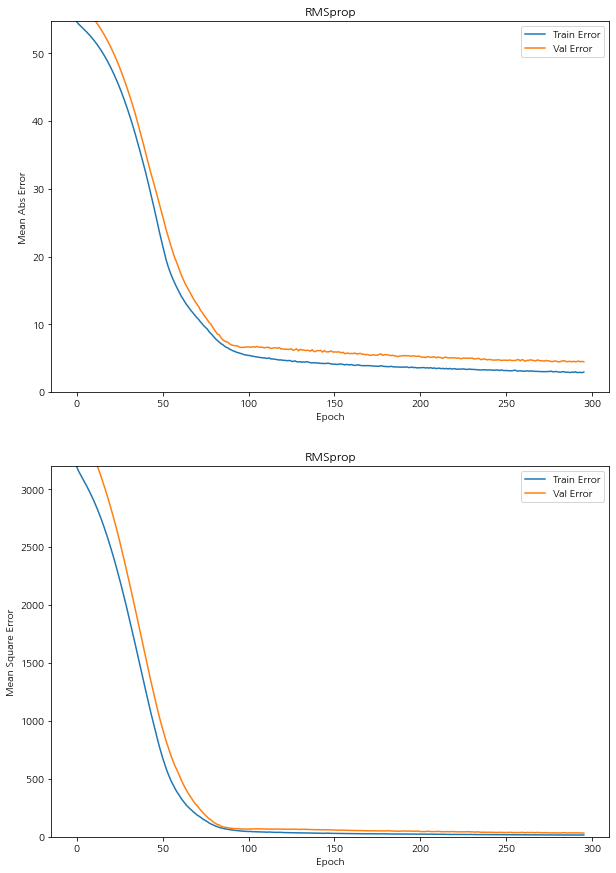

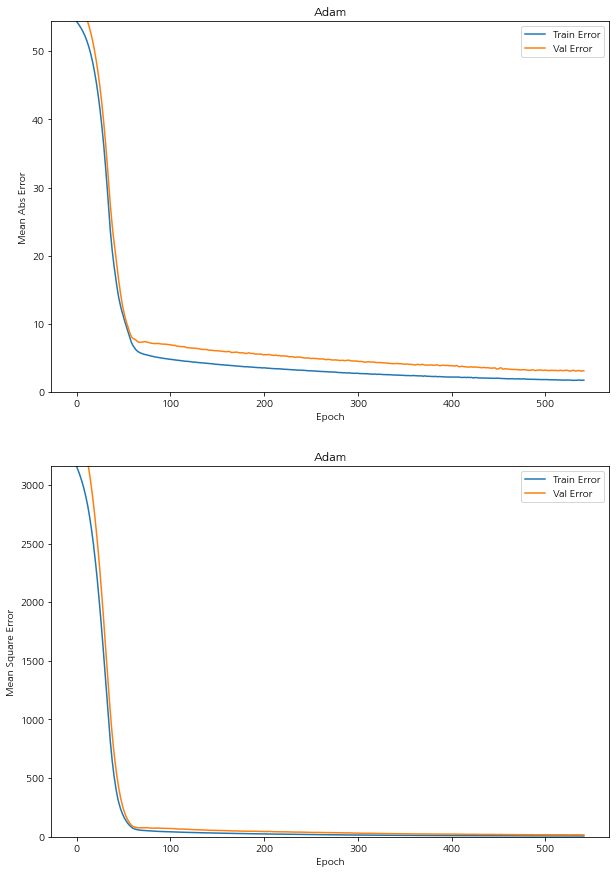

In [45]:
def plot_history(history):
    hist = []
    for i in range(len(history)):
        hist.append(pd.DataFrame(history[i].history))
        hist[i]['epoch'] = history[i].epoch

        plt.figure(figsize=(10,15))

        plt.subplot(2,1,1)
        plt.xlabel('Epoch')
        plt.ylabel('Mean Abs Error')
        plt.plot(hist[i]['epoch'], hist[i]['mean_absolute_error'], label='Train Error')
        plt.plot(hist[i]['epoch'], hist[i]['val_mean_absolute_error'], label = 'Val Error')
        plt.ylim([0,hist[i]['mean_absolute_error'].max()])
        plt.title(model_name[i])
        plt.legend()

        plt.subplot(2,1,2)
        plt.xlabel('Epoch')
        plt.ylabel('Mean Square Error')
        plt.plot(hist[i]['epoch'], hist[i]['mean_squared_error'], label='Train Error')
        plt.plot(hist[i]['epoch'], hist[i]['val_mean_squared_error'], label = 'Val Error')
        plt.ylim([0,hist[i]['mean_squared_error'].max()])
        plt.legend()
        plt.title(model_name[i])
        plt.show()

plot_history(history)

In [46]:
loss, mae, mse = [], [], []
for i in range(len(model)):
    loss, mae, mse = model[i].evaluate(normed_test_data, test_labels, verbose=1)
    print(f'Model = {model_name[i]}')
    print("테스트 세트의 평균 절대 오차: {:5.2f} (MAE)".format(mae))
    print('\n')

30/30 [==============================] - 0s 33us/sample - loss: 5.2054 - mean_absolute_error: 5.2054 - mean_squared_error: 46.8722
Model = RMSprop
테스트 세트의 평균 절대 오차:  5.21 (MAE)


30/30 [==============================] - 0s 67us/sample - loss: 4.0761 - mean_absolute_error: 4.0761 - mean_squared_error: 25.1251
Model = Adam
테스트 세트의 평균 절대 오차:  4.08 (MAE)




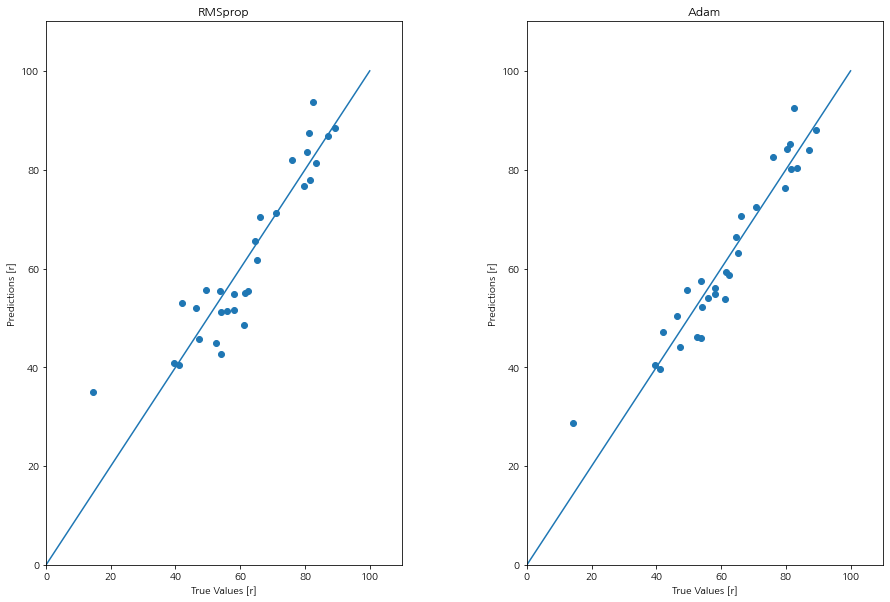

In [47]:
test_predictions = []
for i in range(len(model)):
    test_predictions.append(model[i].predict(normed_test_data).flatten())

fig,axs = plt.subplots(1,2,figsize=(15,10))
plt.subplots_adjust(wspace = 0.35, hspace = 0.25)
axs[0].scatter(test_labels, test_predictions[0])
axs[0].set_title(model_name[0])
axs[0].plot([-100, 100], [-100, 100])
axs[1].scatter(test_labels, test_predictions[1])
axs[1].set_title(model_name[1])
axs[1].plot([-100, 100], [-100, 100])

for ax in axs.flat:
    ax.set(xlabel='True Values [r]', ylabel='Predictions [r]',
          xlim=[0,plt.xlim()[1]], ylim=[0,plt.ylim()[1]])

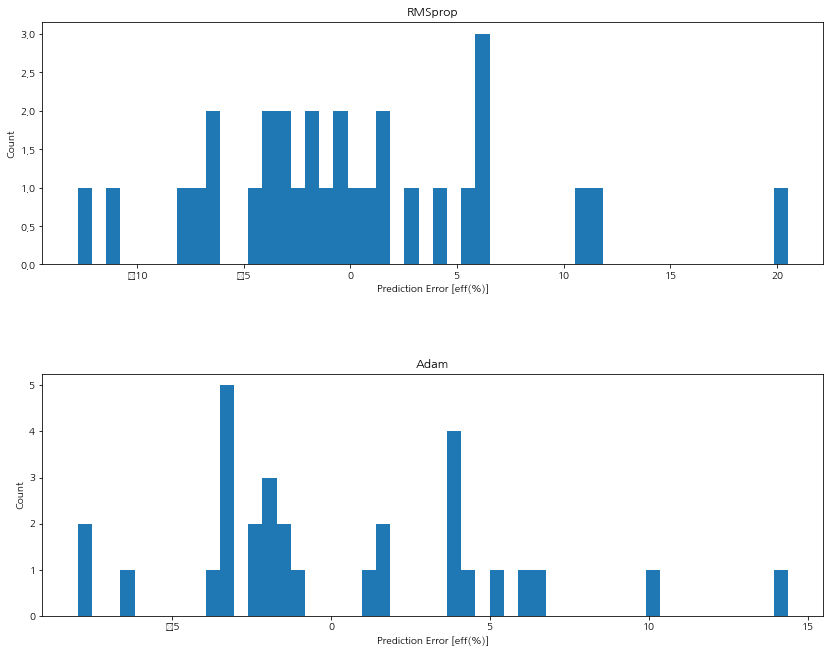

In [48]:
error = []
for i in range(len(model)):
    error.append(test_predictions[i] - test_labels)

fig,axs = plt.subplots(2,1,figsize=(14,10))
plt.subplots_adjust(top=0.95, hspace=0.45)
axs[0].hist(error[0], bins = 50)
axs[0].set_title(model_name[0])
axs[1].hist(error[1], bins = 50)
axs[1].set_title(model_name[1])

for ax in axs.flat:
    ax.set(xlabel='Prediction Error [eff(%)]', ylabel='Count')

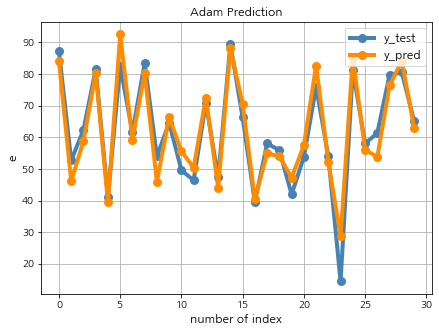

In [49]:
pred_vis(model_name[1], test_labels[:50], test_predictions[1][:50])

In [50]:
'''
model[1].save('C:/Users/sese3/Desktop/Python/seoul metro/Model/model_0724/6185_SGD_1385.h5')
'''

"\nmodel[1].save('C:/Users/sese3/Desktop/Python/seoul metro/Model/model_0724/6185_SGD_1385.h5')\n"

In [51]:
'''
from keras.models import load_model
loaded_model = tf.keras.models.load_model('C:/Users/sese3/Desktop/Python/seoul metro/Model/model_0724/5091_RMSprop_1224.h5')
loaded_model.summary()
'''

"\nfrom keras.models import load_model\nloaded_model = tf.keras.models.load_model('C:/Users/sese3/Desktop/Python/seoul metro/Model/model_0724/5091_RMSprop_1224.h5')\nloaded_model.summary()\n"